# Supervised Learning: Data exploration and enrichment for supervised classification

## Índice

- Introdução
- Bibliotecas
- Leitura do dataset e pré processamento para a posterior análise dos dados
- Análise Exploratória de Dados
- Conclusão do pré-processamento
- Classificação
- Hyperparameter Tuning
- Conclusão


## Introdução

Atualmente, uma quantidade enorme de dados médicos é gerada e armazenada continuamente em hospitais e centros de pesquisa. Para lidar com essa vasta quantidade de informações, é essencial desenvolver métodos eficazes de análise e organização.
Neste notebook, o objetivo é processar os dados de pacientes com Carcinoma Hepatocelular (HCC), fornecidos pelo professor da UC, utilizando a linguagem Python. Pretendemos construir um pipeline de ciência de dados que inclua a análise exploratória, o pré-processamento dos dados e a aplicação de técnicas de 'supervised learning' para prever a sobrevivência dos pacientes com HCC, identificando os fatores clínicos mais relevantes.

## Bibliotecas

Neste notebook são utilizadas várias bibliotecas padrão do Anaconda Python distribution, entre estas:

**NumPy:** É uma biblioteca para a linguagem de programação Python, que suporta o processamento de grandes, multi-dimensionais arranjos e matrizes, juntamente com uma grande coleção de funções matemáticas de alto nível para operar sobre estas matrizes.  
**pandas:** é uma biblioteca de software criada para a linguagem Python para manipulação e análise de dados. Em particular, oferece estruturas e operações para manipular tabelas numéricas e séries temporais.

**scikit-learn:** É uma biblioteca de 'machine learning' de código aberto para a linguagem de programação Python, que inclui vários algoritmos de classificação, regressão e agrupamento. É projetada para interagir com as bibliotecas Python numéricas e científicas NumPy e SciPy.

**matplotlib:** É uma biblioteca de software para a criação de gráficos e visualização de dados no geral, feita para e da linguagem de programação Python e sua extensão de matemática NumPy. 

**Seaborn:** uma biblioteca de visualização de dados Python baseada no matplotlib. Fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.

**imblearn:** É uma biblioteca que fornece ferramentas para lidar com conjuntos de dados desequilibrados, onde as classes não são igualmente representadas. Isso é particularmente útil em problemas de classificação onde uma classe é muito menos representada do que as outras, o que pode prejudicar o desempenho dos algoritmos de ´machine learning'.

**tqdm:** É uma biblioteca utilizada para criar barras de progresso que facilitam o acompanhamento de loops e outras operações demoradas. É especialmente útil em cenários onde se deseja ter uma estimativa de quanto tempo um processo levará para ser concluído.


Para realizar a [instalação do Anaconda](https://www.anaconda.com/download) carregue na hiperligação e faça o download.


In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import seaborn as sns
from utils import *
import math

## Leitura do dataset e pré processamento para a posterior análise dos dados

Primeiramente, começamos por ler os dados com que estamos a trabalhar com o intuito de verificar se existem valores ausentes ou valores nulos, para que possamos proceder ao seu tratamento e fazer uma análise completa do dataset.

In [2]:
df = pd.read_csv("hcc_dataset.csv")
df

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,...,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,Male,No,Yes,No,No,No,No,Yes,No,Yes,...,150,7.1,0.7,1,3.5,0.5,?,?,?,Lives
1,Female,?,No,No,No,No,Yes,Yes,?,?,...,?,?,?,1,1.8,?,?,?,?,Lives
2,Male,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,109,7,2.1,5,13,0.1,28,6,16,Lives
3,Male,Yes,Yes,No,No,No,No,Yes,No,Yes,...,174,8.1,1.11,2,15.7,0.2,?,?,?,Dies
4,Male,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,...,109,6.9,1.8,1,9,?,59,15,22,Lives
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Female,No,Yes,?,?,?,Yes,Yes,No,Yes,...,109,7.6,0.7,5,3,?,?,?,?,Lives
161,Female,Yes,No,?,?,?,?,Yes,No,No,...,280,6.7,0.7,1,2.2,2.3,?,?,?,Dies
162,Male,No,Yes,No,No,No,No,Yes,No,Yes,...,181,7.5,1.46,5,18.6,?,?,?,?,Lives
163,Male,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,...,170,8.4,0.74,5,18,?,?,?,?,Dies


Após uma leitura rápida do dataset, concluimos que as variáveis 'Encephalopathy' e 'Ascites' possuem valores 'NaN', que correspondem a
um paciente que não possui essas características e não a um valor desconhecido( nas outras colunas representado como '?'). Para resolver este problema, vamos substituir os valores desconhecidos 'NaN' por 'None' em ambas as colunas.  

Agora procedemos à transformação dos valores das colunas numéricas em valores numéricos e os valores desconhecidos, '?', por 'Unknown' nas colunas categóricas. 


In [3]:
df["Encephalopathy"].replace({np.nan: "None"}, inplace=True)
df["Ascites"].replace({np.nan: "None"}, inplace=True)

for column in df.columns:
    temp_col = pd.to_numeric(df[column], errors='coerce')
    if temp_col.isna().sum() == (df[column] == '?').sum():
        # Converter os valores para numérico
        df[column] = pd.to_numeric(df[column], errors='coerce')
    else:
        # Substituir '?' por 'Unknown' (categóricos)
        df[column].replace({"?": "Unknown"}, inplace=True)
        
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

df

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,...,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,Male,No,Yes,No,No,No,No,Yes,No,Yes,...,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,Lives
1,Female,Unknown,No,No,No,No,Yes,Yes,Unknown,Unknown,...,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,Lives
2,Male,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,Lives
3,Male,Yes,Yes,No,No,No,No,Yes,No,Yes,...,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,Dies
4,Male,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,...,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,Lives
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Female,No,Yes,Unknown,Unknown,Unknown,Yes,Yes,No,Yes,...,109.0,7.6,0.70,5.0,3.0,NaN,NaN,NaN,NaN,Lives
161,Female,Yes,No,Unknown,Unknown,Unknown,Unknown,Yes,No,No,...,280.0,6.7,0.70,1.0,2.2,2.3,NaN,NaN,NaN,Dies
162,Male,No,Yes,No,No,No,No,Yes,No,Yes,...,181.0,7.5,1.46,5.0,18.6,NaN,NaN,NaN,NaN,Lives
163,Male,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,...,170.0,8.4,0.74,5.0,18.0,NaN,NaN,NaN,NaN,Dies


Vamos agora verificar a percentagem de valores desconhecidos em cada coluna. No caso das colunas categóricas os valores 'Unknown' e no caso das colunas numéricas os valores 'NaN'.

In [4]:
# Calcular o número de ocorrências de "Unknown" em cada coluna
unknown_values_col = ((df == 'Unknown') | (df.isna())).sum()

# Calcular a percentagem de "Unknown" em cada coluna
unknown_percentage_col = (unknown_values_col / len(df)) * 100
unknown_percentage_col = unknown_percentage_col.round(1)
columns_with_unknowns = unknown_percentage_col[unknown_percentage_col > 0].astype(str) + '%'
columns_with_unknowns


Symptoms          10.9%
HBsAg             10.3%
HBeAg             23.6%
HBcAb             14.5%
HCVAb              5.5%
Endemic           23.6%
Smoking           24.8%
Diabetes           1.8%
Obesity            6.1%
Hemochro          13.9%
AHT                1.8%
CRI                1.2%
HIV                8.5%
NASH              13.3%
Varices           31.5%
Spleno             9.1%
PHT                6.7%
PVT                1.8%
Metastasis         2.4%
Hallmark           1.2%
Grams_day         29.1%
Packs_year        32.1%
Encephalopathy     0.6%
Ascites            1.2%
INR                2.4%
AFP                4.8%
Hemoglobin         1.8%
MCV                1.8%
Leucocytes         1.8%
Platelets          1.8%
 Albumin           3.6%
Total_Bil          3.0%
ALT                2.4%
AST                1.8%
GGT                1.8%
ALP                1.8%
TP                 6.7%
Creatinine         4.2%
Nodules            1.2%
Major_Dim         12.1%
Dir_Bil           26.7%
Iron            

De forma a não existirem valores desconhecidos das features numéricas no dataset, vamos encontrar a melhor estratégia para os substituir. Para isso vamos experimentar usar o KNNImputer e o SimpleImputer.
 
O KNNImputer é uma técnica usada para preencher valores ausentes num conjunto de dados.Usa o algoritmo K-Nearest Neighbors (KNN) para fazer esse preenchimento a partir das semelhanças entre o resto das amostras do conjunto de dados, de acordo com o número de vizihos (no nosso caso 5).
O SimpleImputer é uma técnica que substitui os valores ausentes por um valor específico, como a média, a mediana ou o valor mais frequente da coluna (neste caso, a média).
 

In [5]:
#Usando o KNNImputer para preencher os valores ausentes
df[numeric_features] = df[numeric_features].replace('Unknown', np.nan)

#knn_imputer = KNNImputer(n_neighbors=5)
#df[numeric_features] = knn_imputer.fit_transform(df[numeric_features])

# Usar SimpleImputer para substituir NaNs pela média
imputer = SimpleImputer(strategy='mean')
df[numeric_features] = imputer.fit_transform(df[numeric_features])

Após verificarmos que o SimpleImputer é a estratégia que melhor se adequa ao nosso dataset e que apresenta melhores resultados finais (accuracy), vamos usar esta técnica para preencher os valores ausentes nas colunas numéricas e comentar as linhas de código com o KNNImputer.

In [6]:
# Initialize an empty list to store column names with more 'Unknowns'
columns_with_more_unknowns = []

# Iterate through each column in the DataFrame
for column in df.columns:
    counts = df[column].value_counts()

    # Check if 'Unknown' count is greater than 'Yes' or 'No' count individually
    if counts.get('Unknown', 0) > counts.get('Yes', 0) or counts.get('Unknown', 0) > counts.get('No', 0):
        columns_with_more_unknowns.append(column)

columns_with_more_unknowns

['HBsAg',
 'HBeAg',
 'Endemic',
 'Hemochro',
 'HIV',
 'NASH',
 'Varices',
 'Encephalopathy',
 'Ascites']

Mais à frente vamos testar a performance dos modelos de classificação com e sem estas colunas.

## Análise Exploratória de Dados

Vamos começar por analisar o número de linhas e colunas do dataset, o tipo de cada feature e a distribuição de características categóricas.

In [7]:
#Analisar o número de linhas e colunas
shape = df.shape
print("Number of rows: ", shape[0])
print("Number of columns: ", shape[1])

Number of rows:  165
Number of columns:  50


In [8]:
#Analisar o type das features
print(df.dtypes)

Gender             object
Symptoms           object
Alcohol            object
HBsAg              object
HBeAg              object
HBcAb              object
HCVAb              object
Cirrhosis          object
Endemic            object
Smoking            object
Diabetes           object
Obesity            object
Hemochro           object
AHT                object
CRI                object
HIV                object
NASH               object
Varices            object
Spleno             object
PHT                object
PVT                object
Metastasis         object
Hallmark           object
Age               float64
Grams_day         float64
Packs_year        float64
PS                 object
Encephalopathy     object
Ascites            object
INR               float64
AFP               float64
Hemoglobin        float64
MCV               float64
Leucocytes        float64
Platelets         float64
 Albumin          float64
Total_Bil         float64
ALT               float64
AST         

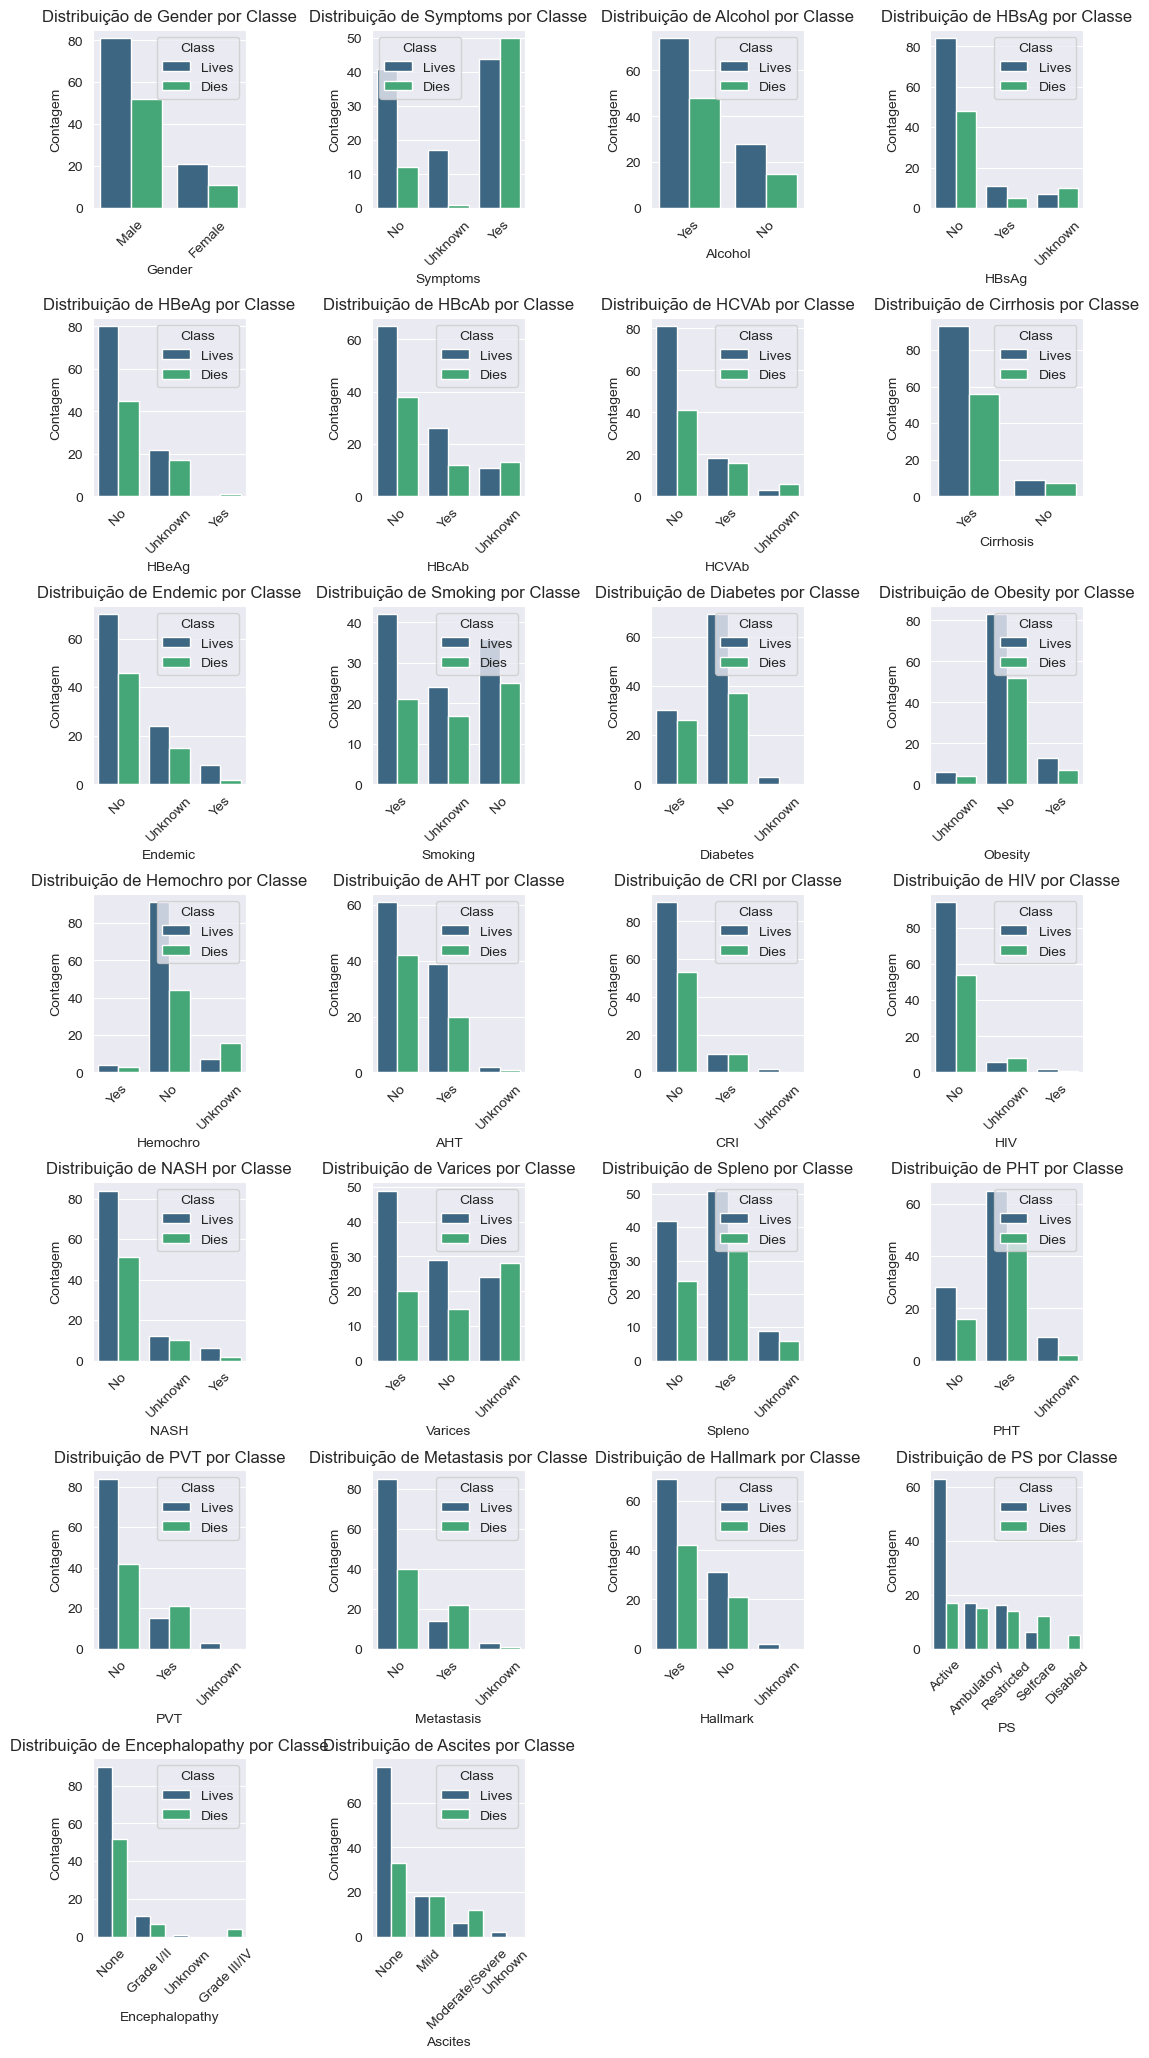

In [9]:
#Gráficos de distribuição de características categóricas

# Identificar todas as características categóricas
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Excluir a label 'Class' da lista
categorical_features = [feature for feature in categorical_features if feature != 'Class']

# Determina o número de gráficos por linha
num_cols = 4
num_features = len(categorical_features)
num_rows = math.ceil(num_features / num_cols)

# Cria a figura e os eixos de subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

# Ajusta o layout para evitar sobreposição
fig.tight_layout(pad=6.0)

# Itera sobre as características categóricas e cria os gráficos
for idx, feature in enumerate(categorical_features):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]
    sns.countplot(x=feature, hue='Class', data=df, palette='viridis', ax=ax)
    ax.set_title(f'Distribuição de {feature} por Classe')
    ax.set_ylabel('Contagem')
    ax.tick_params(axis='x', rotation=45)

# Remove eixos vazios
for idx in range(num_features, num_rows * num_cols):
    fig.delaxes(axs.flatten()[idx])

plt.show()

Vamos agora desenhar uma matriz de correlação para ajudar a identificar colunas ou variáveis que possam ser redundantes. Cada célula da matriz representa a correlação entre duas variáveis específicas. A correlação mede a força e a direção do relacionamento linear entre duas variáveis. Uma correlação próxima de 1 indica uma relação positiva, enquanto uma correlação próxima de -1 indica uma relação negativa. 


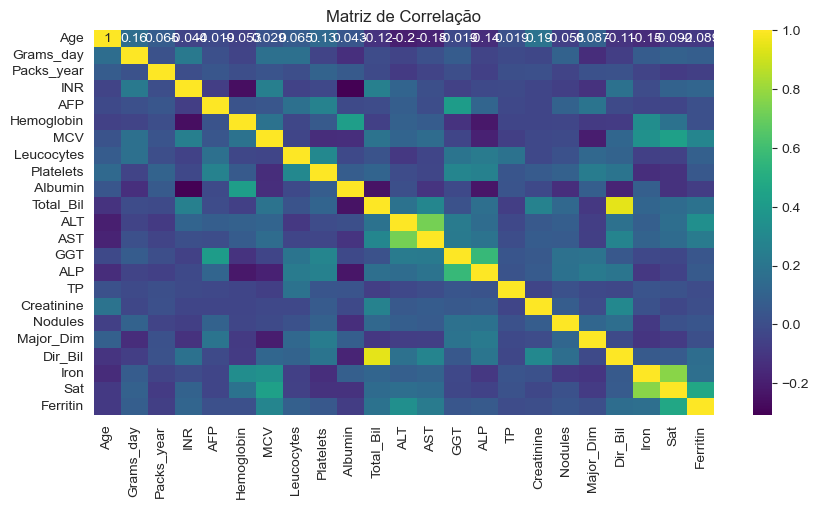

In [10]:
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title("Matriz de Correlação")
plt.show()

Pela análise da matriz de correlação, podemos concluir que as features 'Dir_Bil' e 'Total_Bil' têm uma correlação muito próxima de 1, o que sugere que uma delas pode ser redundante. E assim, em baixo, testaremos retirar uma das features.



Passamos agora à análise dos possíveis outliers nas variáveis numéricas. Os outliers correspondem a valores que se encontram fora do intervalo esperado ou de uma distribuição normal.

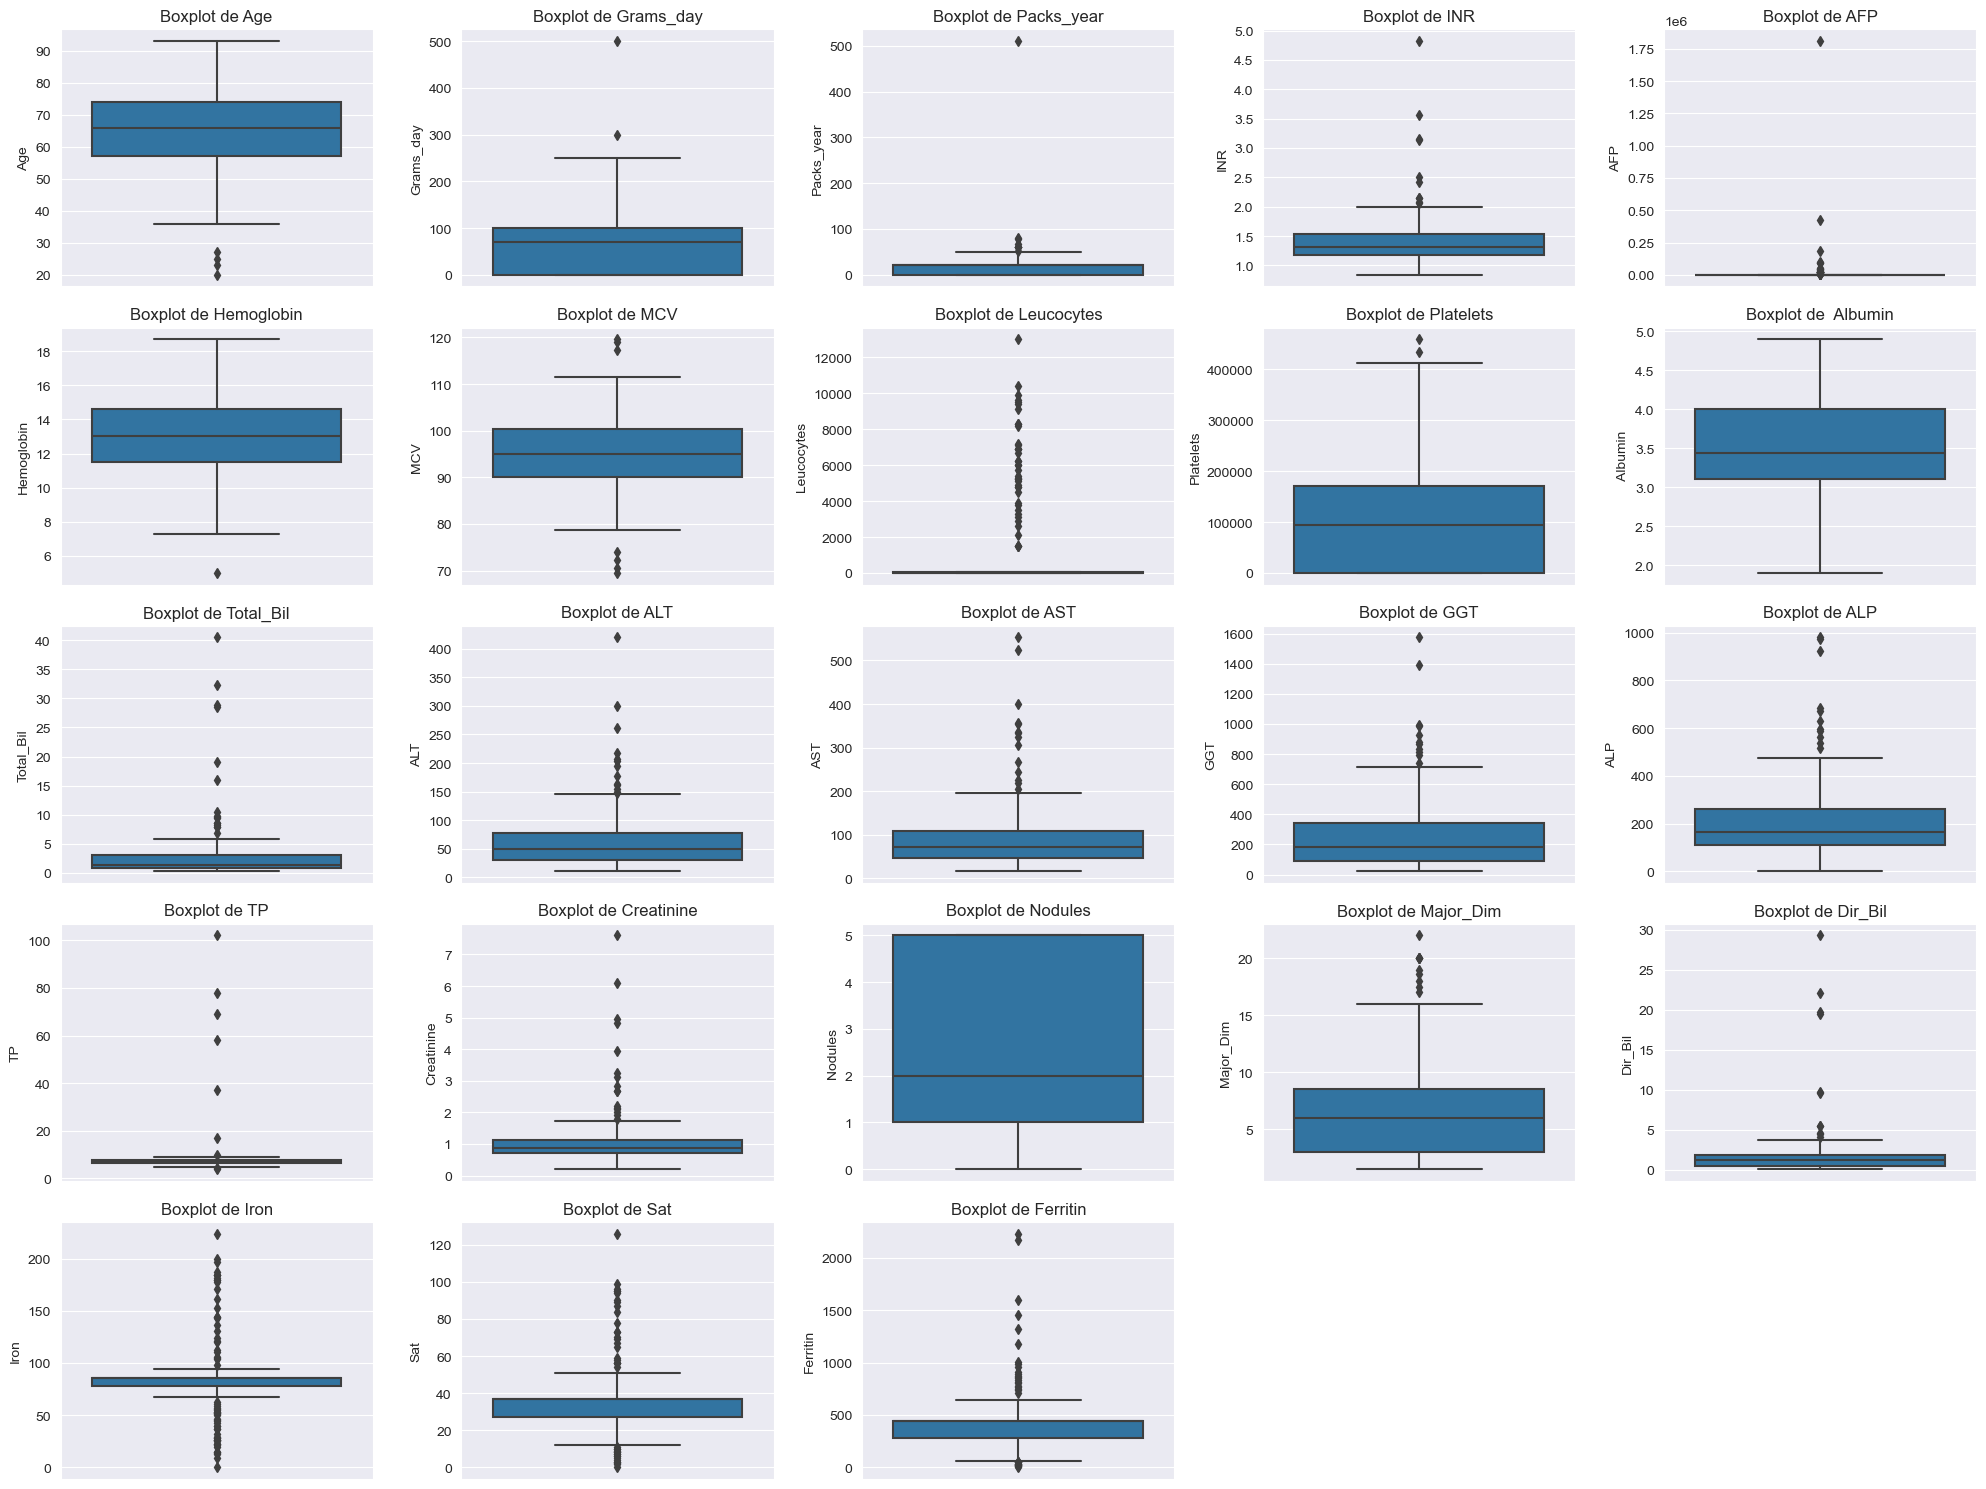

In [11]:
#Identifica possíveis outliers nas variáveis numéricas
plt.figure(figsize=(20, 15))
numeric_features = df.select_dtypes(include=['float64']).columns.tolist()
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot de {feature}')
plt.tight_layout()
plt.show()

## Conclusão do pré-processamento 

De modo a não existirem valores desconhecidos nas features categóricas, vamos usar o SimpleImputer, já mencionado acima, para substituir esses valores desconhecidos pelo valor mais frequente da coluna.

In [12]:
df.replace('Unknown', np.nan, inplace=True)

In [13]:
features, label = split(df, ['Class'])

In [14]:
features

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,...,PS_Ambulatory,PS_Disabled,PS_Restricted,PS_Selfcare,Encephalopathy_Grade I/II,Encephalopathy_Grade III/IV,Encephalopathy_None,Ascites_Mild,Ascites_Moderate/Severe,Ascites_None
0,67.0,137.000000,15.000000,1.530000,95.000000,13.700000,106.600000,4.900000,99.000000,3.400000,...,False,False,False,False,False,False,True,False,False,True
1,62.0,0.000000,20.464286,1.421851,19299.951146,12.879012,95.119753,1473.961549,113206.442654,3.445535,...,False,False,False,False,False,False,True,False,False,True
2,78.0,50.000000,50.000000,0.960000,5.800000,8.900000,79.800000,8.400000,472.000000,3.300000,...,True,False,False,False,False,False,True,True,False,False
3,77.0,40.000000,30.000000,0.950000,2440.000000,13.400000,97.100000,9.000000,279.000000,3.700000,...,False,False,False,False,False,False,True,False,False,True
4,76.0,100.000000,30.000000,0.940000,49.000000,14.300000,95.100000,6.400000,199.000000,4.100000,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,40.0,71.008547,20.464286,0.840000,19299.951146,15.400000,109.200000,9.300000,184000.000000,4.600000,...,False,False,False,False,False,False,True,False,False,True
161,68.0,0.000000,0.000000,1.330000,4887.000000,12.100000,88.900000,2.500000,141.000000,3.000000,...,True,False,False,False,False,False,True,False,False,True
162,65.0,71.008547,48.000000,1.130000,75.000000,13.300000,90.000000,8.000000,385000.000000,4.300000,...,False,False,False,False,False,False,True,False,False,True
163,44.0,71.008547,20.464286,2.140000,94964.000000,15.600000,117.300000,5200.000000,118000.000000,4.800000,...,True,False,False,False,False,False,True,False,False,True


Vamos verificar o desbalanceamento do dataset.

In [15]:
label.value_counts()

Class
Lives    102
Dies      63
Name: count, dtype: int64

Como existe desbalanceamento, vamos usar o SMOTE. 

O SMOTE é usado para balancear o conjunto de train antes de treinar o modelo. Ao usar SMOTE, garantimos que o modelo recebe um conjunto de treino mais balanceado, o que geralmente resulta num desempenho melhor e mais justo ao avaliar os modelo em dados desbalanceados.

## Classificação

Os modelos de clasificação que vamos usar são:
- Decision Tree Classifier
- Random Forest Classifier
- KNN Classifier
- Gradient Boosting Classifier


Agora que o dataset não apresenta valores desconhecidos e já está analisado e pré-processado, vamos implementar estes 4 modelos de classificação (ainda sem hiperparâmetros estudados) e avaliá-los.

In [16]:
def instanciate_models():
    return {
        'Decision Tree': {
            'model': DecisionTreeClassifier(), 
            'best_params': None,
        },
        'Random Forest': {
            'model': RandomForestClassifier(), 
            'best_params': None,
        },
        'KNN': {
            'model': KNeighborsClassifier(), 
            'best_params': None,
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(),
            'best_params': None,
        }
    }
    
models = instanciate_models()

## 1ª Tentativa

Nesta primeira tentativa é usado o dataset pré-processado, sem mais nenhuma alteração.

Agora vamos observar a accuracy, a matriz de confusão e a cross validation para cada um dos modelos.

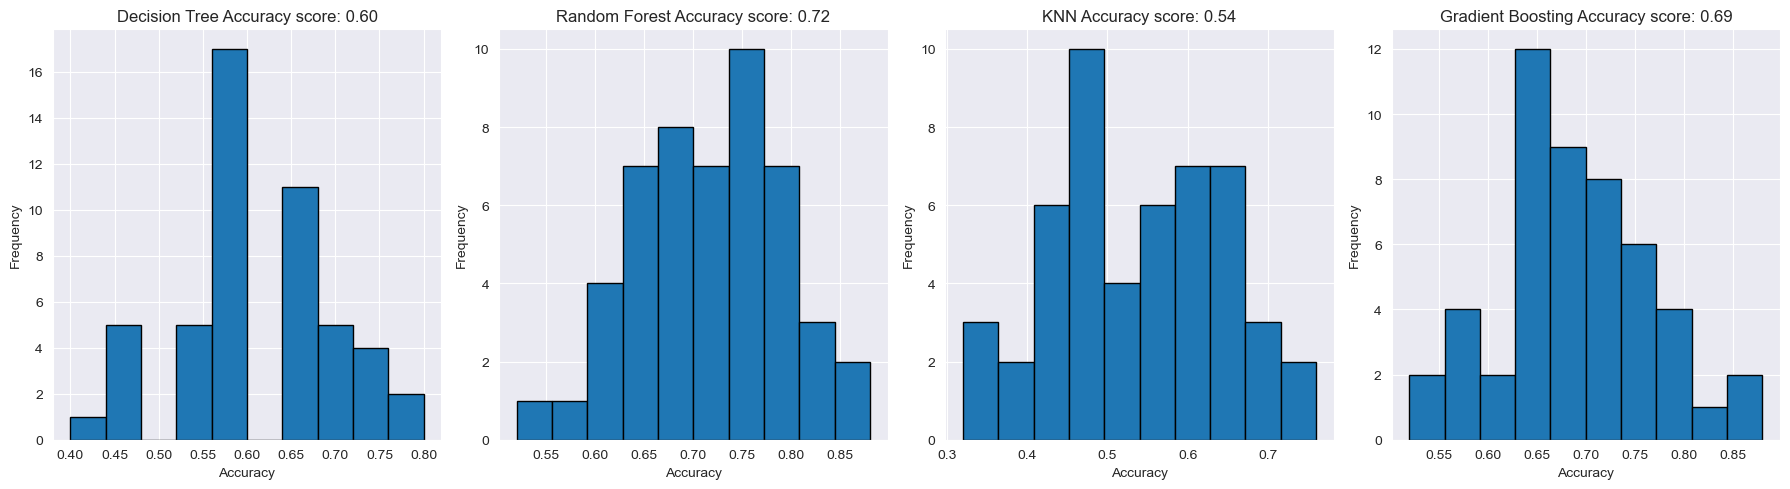

In [17]:
plot_histograms(models, hold_out_evaluate, features, label)

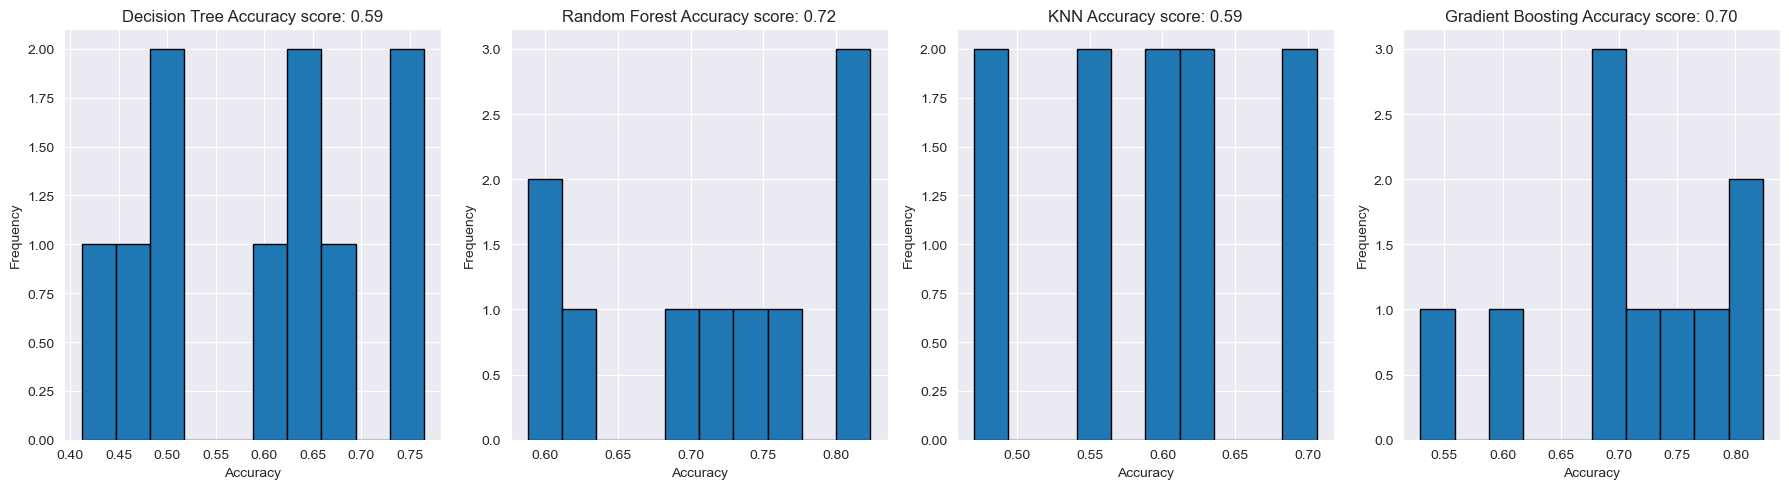

In [18]:
plot_histograms(models, cross_val_evaluate, features, label)

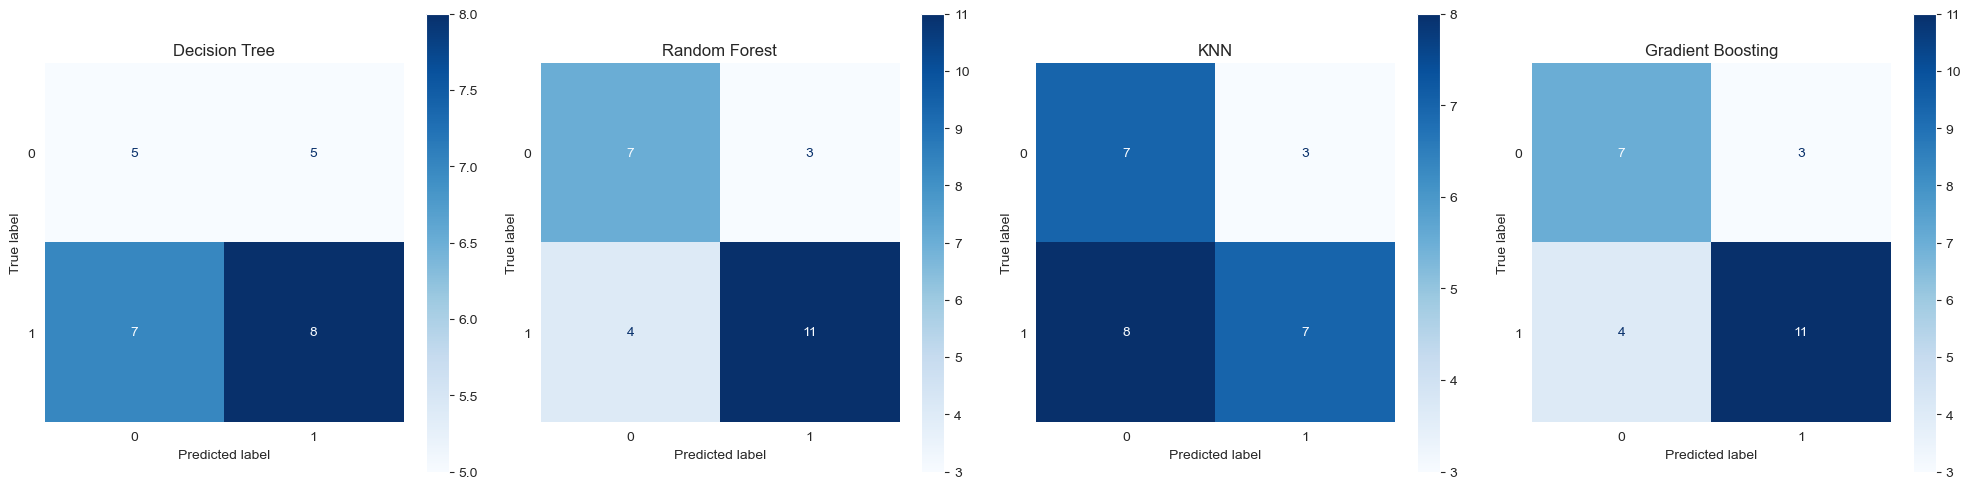

In [19]:
confusion_matrix_plot(models, features, label)

Agora, através da função report, vamos calssificar a performance dos modelos. A partir desta função conseguimos observar a precisão, recall, f1-score e a média de todas as métricas para cada um dos modelos.

In [20]:
report(models, features, label)

Model: Decision Tree
              precision    recall  f1-score   support

        Dies       0.50      0.42      0.45        12
       Lives       0.53      0.62      0.57        13

    accuracy                           0.52        25
   macro avg       0.52      0.52      0.51        25
weighted avg       0.52      0.52      0.52        25

Model: Random Forest
              precision    recall  f1-score   support

        Dies       0.80      0.73      0.76        11
       Lives       0.80      0.86      0.83        14

    accuracy                           0.80        25
   macro avg       0.80      0.79      0.79        25
weighted avg       0.80      0.80      0.80        25

Model: KNN
              precision    recall  f1-score   support

        Dies       0.70      0.47      0.56        15
       Lives       0.47      0.70      0.56        10

    accuracy                           0.56        25
   macro avg       0.58      0.58      0.56        25
weighted avg       0.

## 2ª Tentativa

Nesta segunda tentativa, como já mencionado acima, vamos retirar as features com mais valors 'Unknown' do que 'Yes' ou 'No'. 

In [21]:
features2, label2 = split(df, ['Class']+columns_with_more_unknowns)
models = instanciate_models()

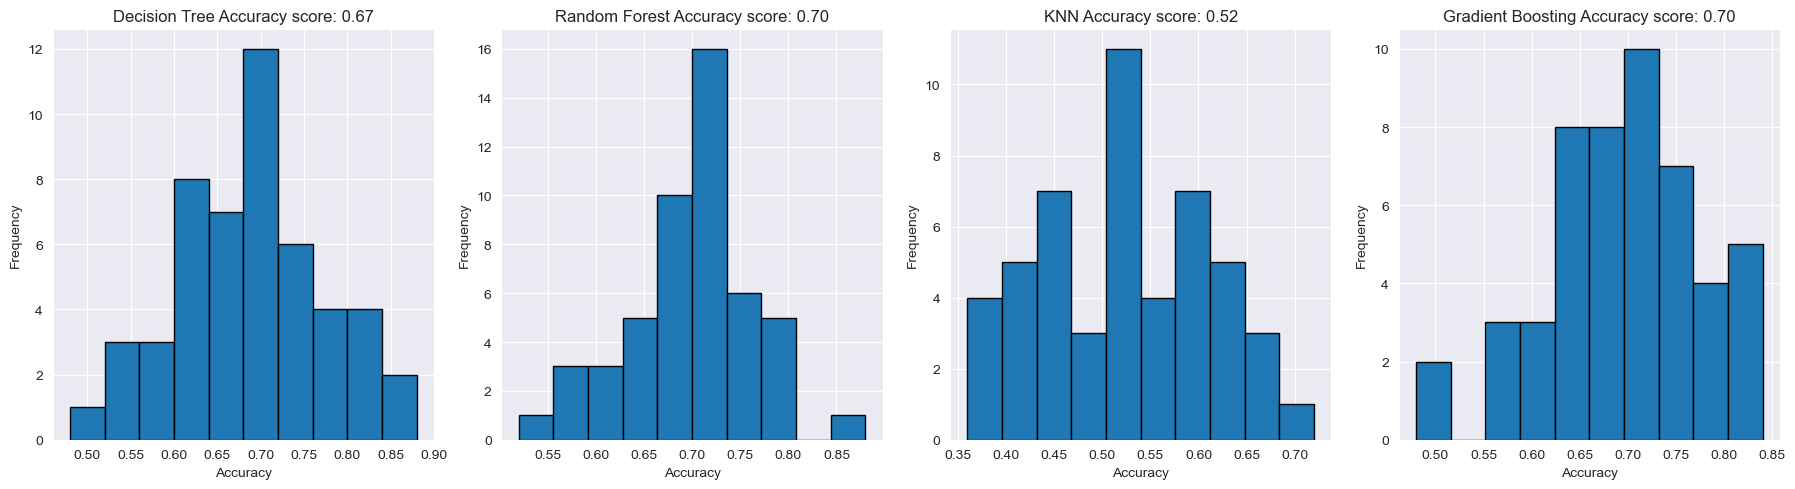

In [22]:
plot_histograms(models, hold_out_evaluate, features2, label2)

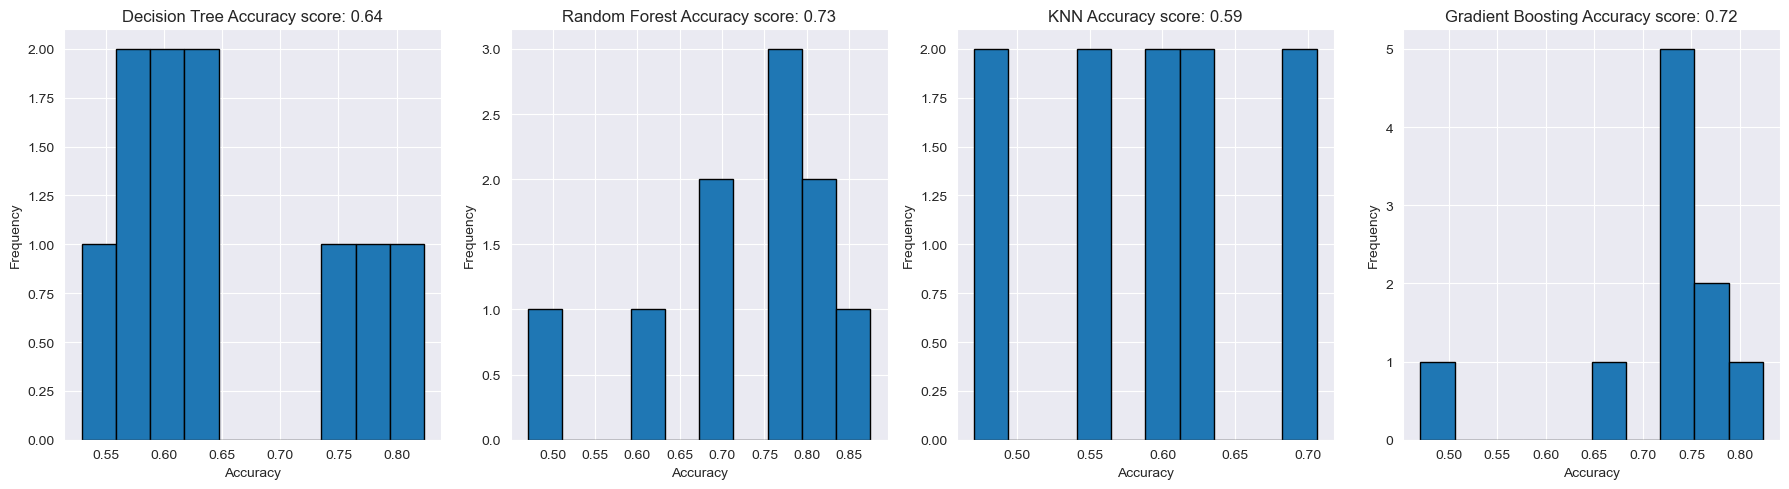

In [23]:
plot_histograms(models, cross_val_evaluate, features2, label2)

In [24]:
report(models, features2, label2)

Model: Decision Tree
              precision    recall  f1-score   support

        Dies       0.60      0.46      0.52        13
       Lives       0.53      0.67      0.59        12

    accuracy                           0.56        25
   macro avg       0.57      0.56      0.56        25
weighted avg       0.57      0.56      0.56        25

Model: Random Forest
              precision    recall  f1-score   support

        Dies       0.90      0.69      0.78        13
       Lives       0.73      0.92      0.81        12

    accuracy                           0.80        25
   macro avg       0.82      0.80      0.80        25
weighted avg       0.82      0.80      0.80        25

Model: KNN
              precision    recall  f1-score   support

        Dies       0.70      0.47      0.56        15
       Lives       0.47      0.70      0.56        10

    accuracy                           0.56        25
   macro avg       0.58      0.58      0.56        25
weighted avg       0.

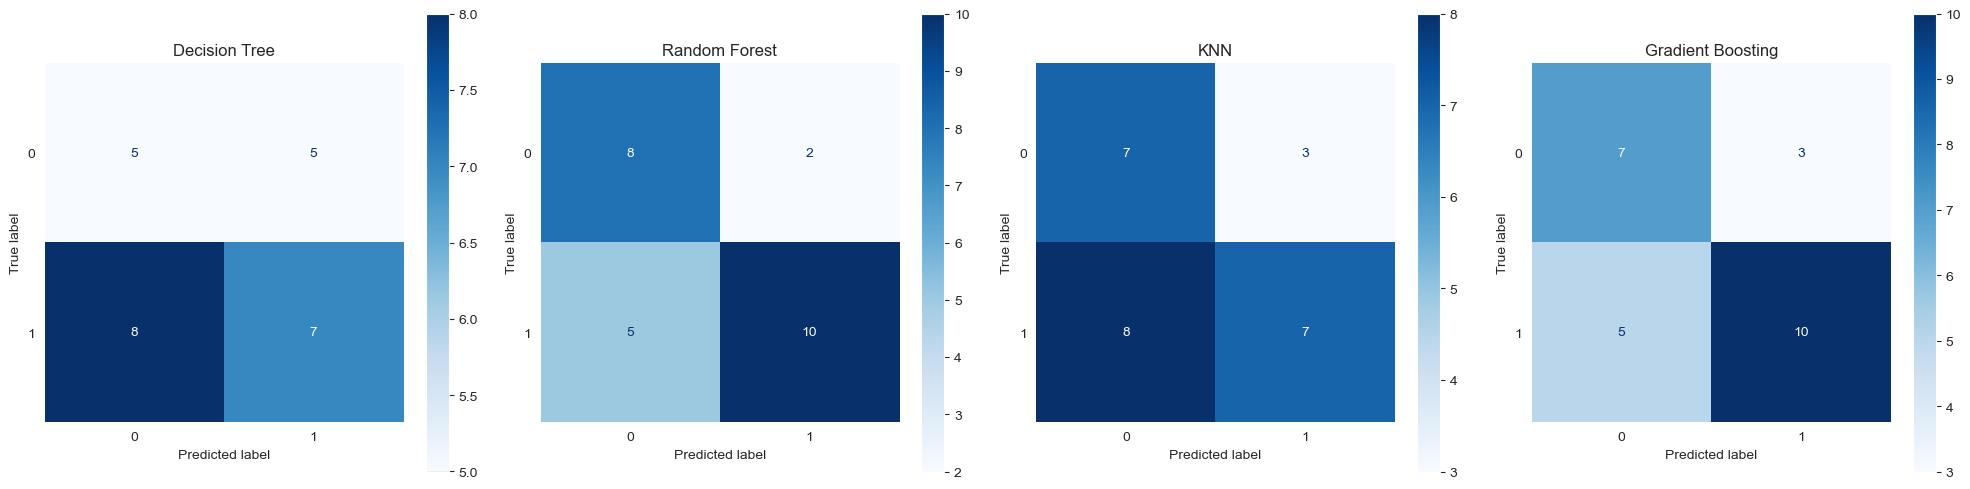

In [25]:
confusion_matrix_plot(models, features2, label2)

## 3ª Tentativa

Nesta terceira tentativa vamos retirar as colunas: 

- 'Total_Bil'(por ter uma correlação muito próxima de 1 com a feature 'Dir_Bil'), 
- 'Varices' (por possuir um elevado valor de 'Unknown' quase equivalente ao valor 'No')
- 'Smoking' e 'Alcohol' (por serem colunas irrelevantes, uma vez que já se calcula o consumo de álcool e tabaco através de outras features)

In [39]:
features3, label3 = split(df, ['Class', 'Varices', 'Smoking', 'Alcohol', 'Total_Bil'])
models = instanciate_models()

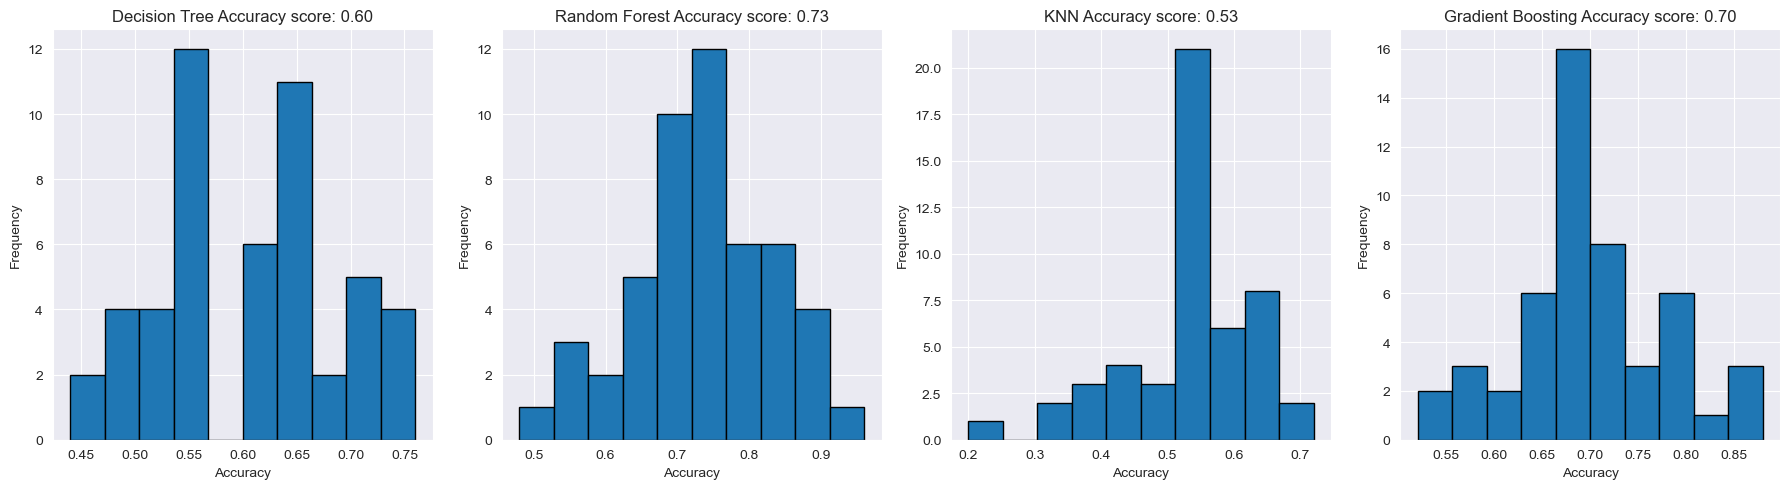

In [27]:
plot_histograms(models, hold_out_evaluate, features3, label3)

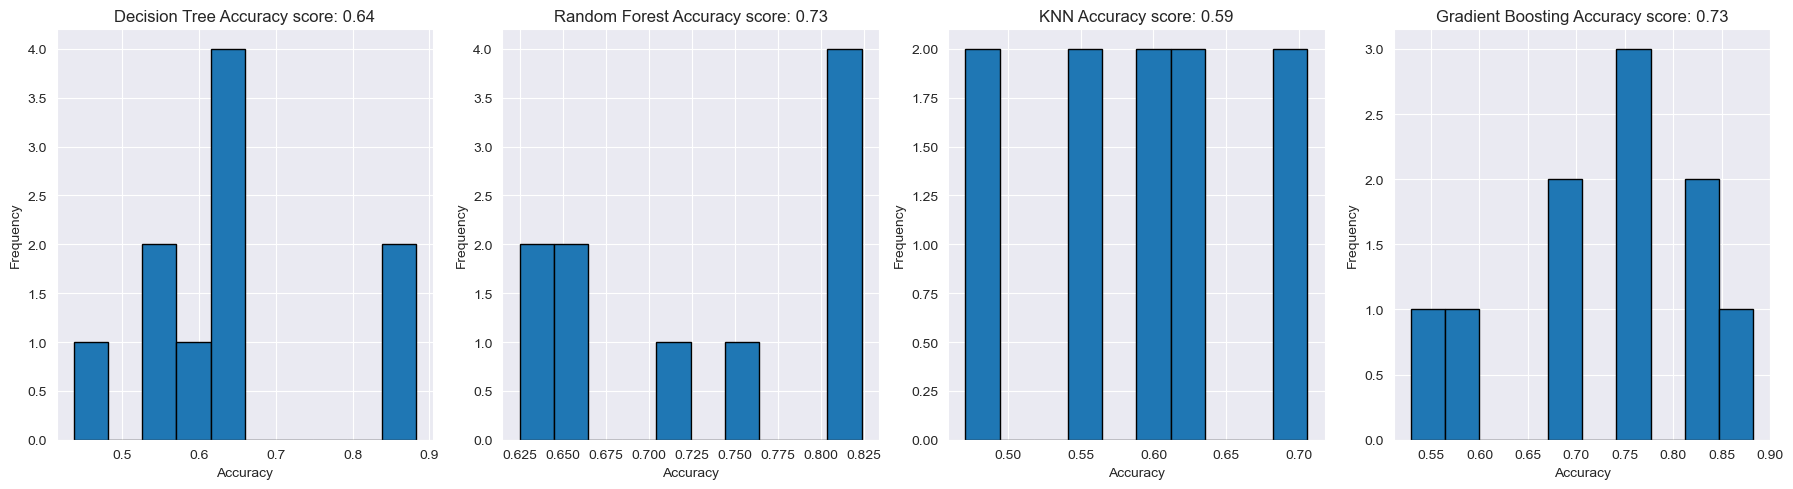

In [28]:
plot_histograms(models, cross_val_evaluate, features3, label3)

In [29]:
report(models, features3, label3)

Model: Decision Tree
              precision    recall  f1-score   support

        Dies       0.50      0.38      0.43        13
       Lives       0.47      0.58      0.52        12

    accuracy                           0.48        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.48      0.48      0.47        25

Model: Random Forest
              precision    recall  f1-score   support

        Dies       0.80      0.73      0.76        11
       Lives       0.80      0.86      0.83        14

    accuracy                           0.80        25
   macro avg       0.80      0.79      0.79        25
weighted avg       0.80      0.80      0.80        25

Model: KNN
              precision    recall  f1-score   support

        Dies       0.70      0.47      0.56        15
       Lives       0.47      0.70      0.56        10

    accuracy                           0.56        25
   macro avg       0.58      0.58      0.56        25
weighted avg       0.

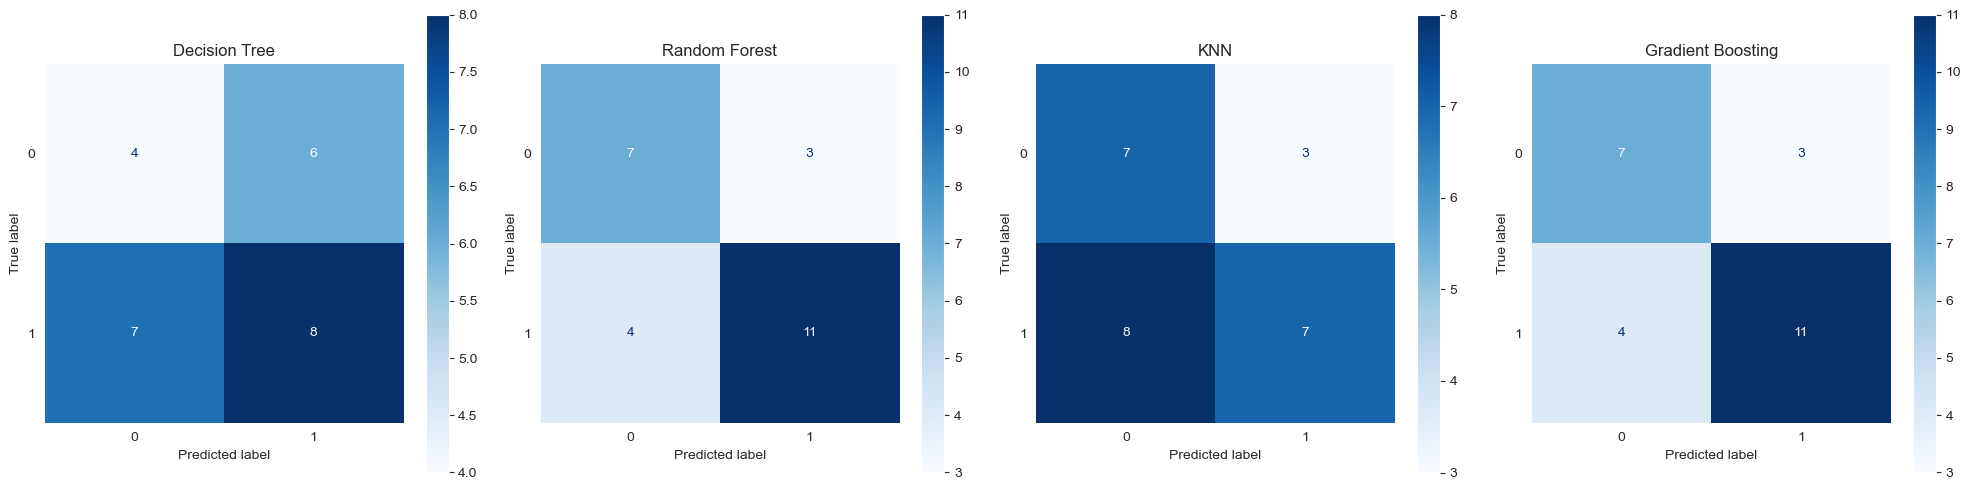

In [30]:
confusion_matrix_plot(models, features3, label3)

## Hyperparameter Tuning

Como a 2ª e a 3ª tentativa têm resultados semelhantes, vamos agora fazer o tuning dos hiperparâmetros dos modelos de classificação da 3ª tenativa(exemplo).

In [40]:
models = instanciate_models()

# Definir os grids de hiperparâmetros
param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 10],
        'bootstrap': [True, False]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.05],
        'max_depth': [3, 4, 5, 6, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

X_train, X_test, y_train, y_test = train_split(features3, label3, random_state=42)

# Realizar o Grid Search para cada modelo
for model_name,model_dict in tqdm(models.items(), desc="Tuning hyperparameters"):
    print(f"Tuning hyperparameters for {model_name}")
    grid_search = GridSearchCV(estimator=model_dict['model'], param_grid=param_grids[model_name], scoring='accuracy', cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
    model_dict['best_params'] = grid_search.best_params_
    print(f"Best accuracy for {model_name}: {grid_search.best_score_}")

    # Testar o melhor modelo no conjunto de teste
    best_model = grid_search.best_estimator_
    accuracy = best_model.score(X_test, y_test)
    print(f"Accuracy on test set for {model_name}: {accuracy}\n")
    


Tuning hyperparameters:   0%|          | 0/4 [00:00<?, ?it/s]

Tuning hyperparameters for Decision Tree


Tuning hyperparameters:  25%|██▌       | 1/4 [00:12<00:36, 12.13s/it]

Best hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy for Decision Tree: 0.719281045751634
Accuracy on test set for Decision Tree: 0.64

Tuning hyperparameters for Random Forest


Tuning hyperparameters:  50%|█████     | 2/4 [06:27<07:31, 225.54s/it]

Best hyperparameters for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy for Random Forest: 0.8284313725490197
Accuracy on test set for Random Forest: 0.76

Tuning hyperparameters for KNN


Tuning hyperparameters:  75%|███████▌  | 3/4 [06:31<02:04, 124.51s/it]

Best hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best accuracy for KNN: 0.7022875816993464
Accuracy on test set for KNN: 0.64

Tuning hyperparameters for Gradient Boosting


Tuning hyperparameters: 100%|██████████| 4/4 [13:01<00:00, 195.49s/it]

Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy for Gradient Boosting: 0.8169934640522877
Accuracy on test set for Gradient Boosting: 0.68



In [41]:
for model_name,model_dict in models.items():
    model_dict['model'].set_params(**model_dict['best_params'])
    model_dict['model'].fit(X_train, y_train)

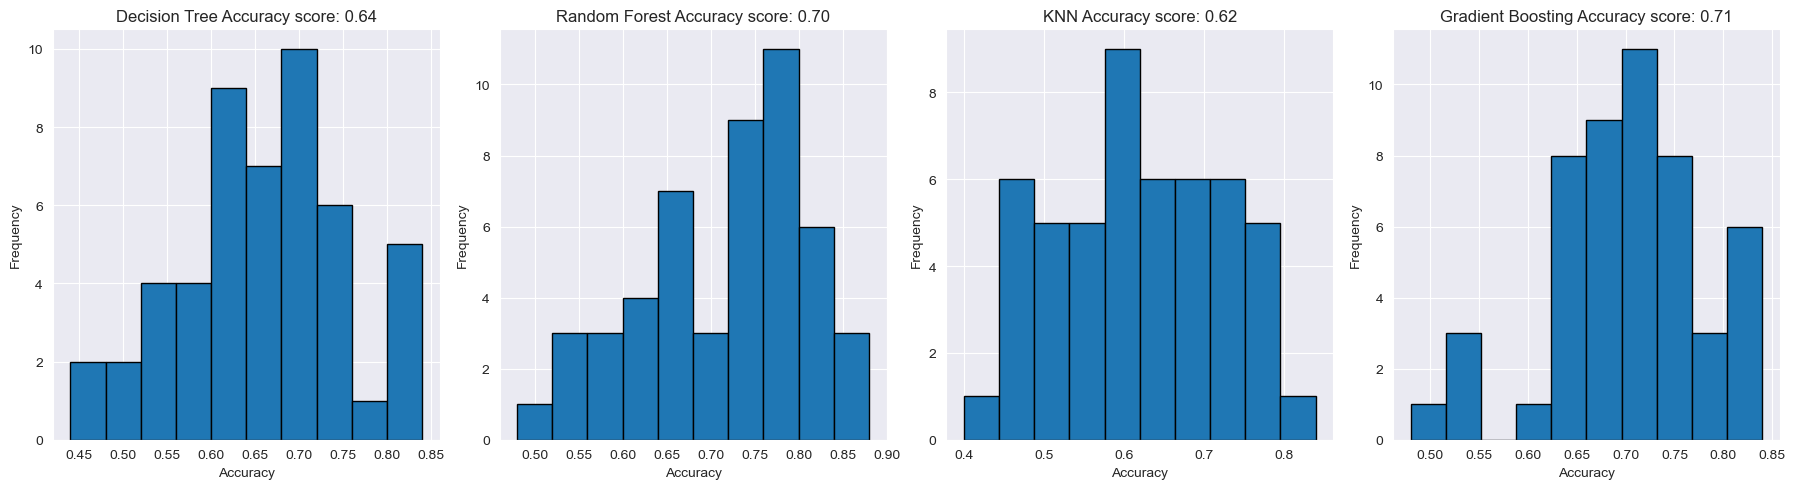

In [42]:
plot_histograms(models, hold_out_evaluate, features, label)

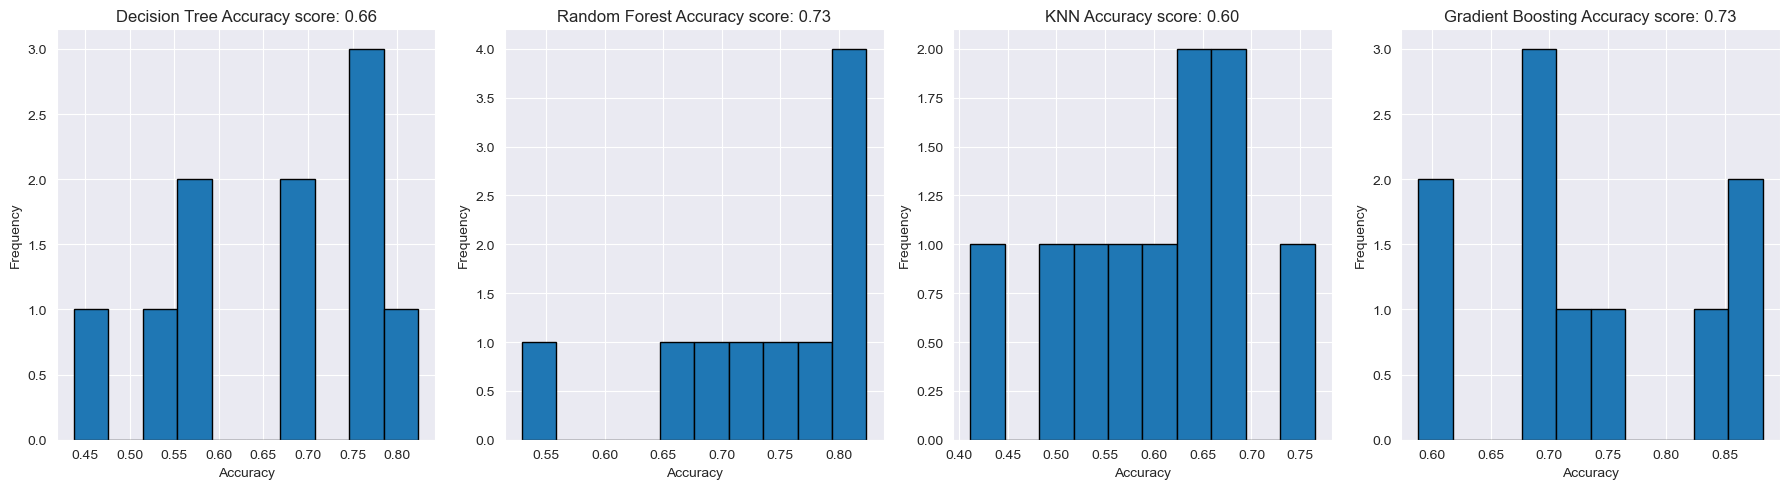

In [43]:
plot_histograms(models, cross_val_evaluate, features, label)

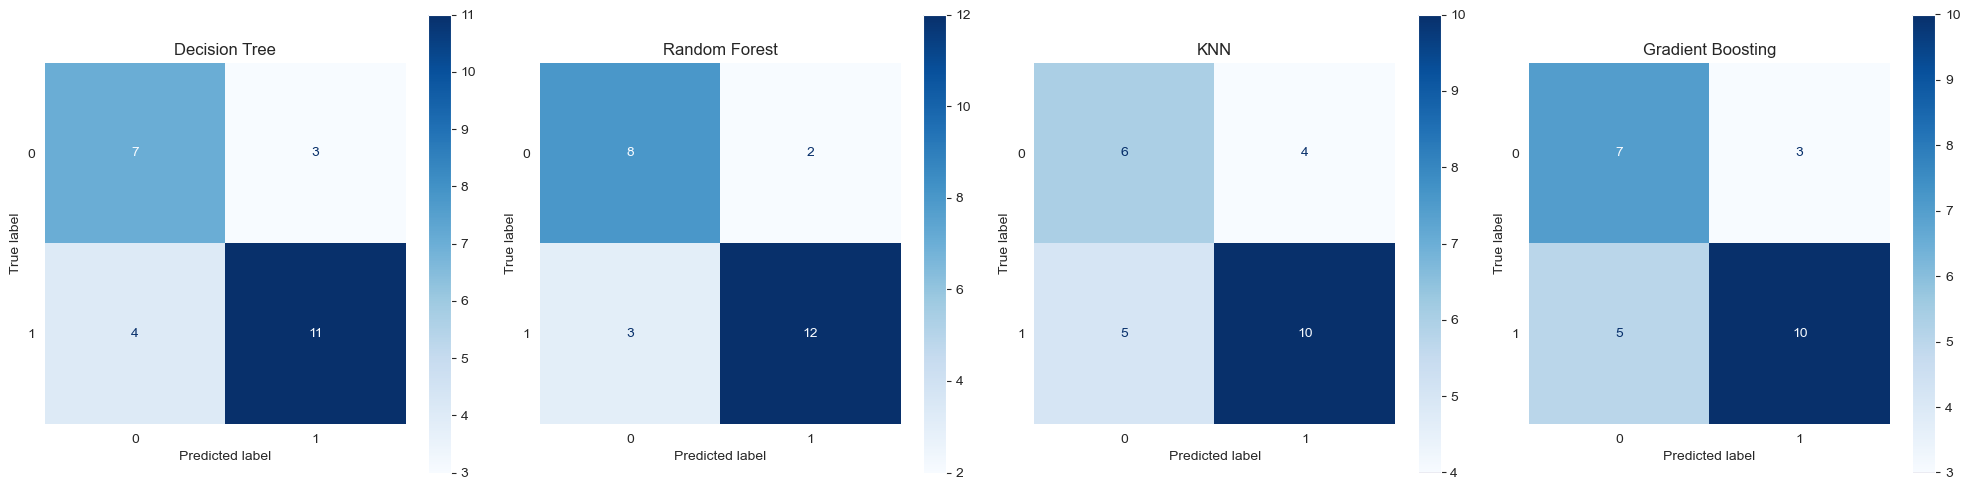

In [44]:
confusion_matrix_plot(models, features, label)

In [45]:
report(models, features, label)

Model: Decision Tree
              precision    recall  f1-score   support

        Dies       0.70      0.58      0.64        12
       Lives       0.67      0.77      0.71        13

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.68        25
weighted avg       0.68      0.68      0.68        25

Model: Random Forest
              precision    recall  f1-score   support

        Dies       0.70      0.58      0.64        12
       Lives       0.67      0.77      0.71        13

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.68        25
weighted avg       0.68      0.68      0.68        25

Model: KNN
              precision    recall  f1-score   support

        Dies       0.60      0.55      0.57        11
       Lives       0.67      0.71      0.69        14

    accuracy                           0.64        25
   macro avg       0.63      0.63      0.63        25
weighted avg       0.

## Conclusão

Com base na análise dos resultados obtidos, concluímos que o modelo RandomForestClassifier foi o melhor para o conjunto de dados fornecido. Fizemos uma comparação entre os quatro modelos implementados neste trabalho: DecisionTree, K-Nearest Neighbors, RandomForestClassifier e Gradient Boosting. O RandomForestClassifier apresentou a melhor accuracy entre os quatro.

Um ponto importante neste trabalho foi a análise do conjunto de dados. A eliminação de colunas irrelevantes, baseada na nossa análise do dataset, ajudou a alcançar uma accuracy elevada e resultados confiáveis.

Em resumo, concluímos que o melhor modelo para o conjunto de dados fornecido é o RandomForestClassifier. Além disso, a análise e o tratamento dos dados são tão importantes quanto a implementação do modelo.